In [28]:
import pandas as pd
from umap import UMAP
from ivis import Ivis
import numpy as np
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
from hdbscan import HDBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tqdm.pandas(desc="progess: ")

In [21]:
# parameters
data_path = "/home/philipp/projects/dad4td/data/external/20_newsgroup/20_newsgroup.csv"
#doc2vec_model_path = "/home/philipp/projects/dad4td/models/apnews_dbow/doc2vec.bin"
doc2vec_model_path = "/home/philipp/projects/dad4td/models/enwiki_dbow/doc2vec.bin"
doc2vec_model = Doc2Vec.load(doc2vec_model_path)

# get test data
df = pd.read_csv(data_path)
df.text = df.text.astype(str)
df = df.where(df.text.map(len) > 5)

# vectorize
df

Unnamed: 0                                               text  target  \
0             0.0  I was wondering if anyone out there could enli...     7.0   
1            17.0  I recently posted an article asking what kind ...     7.0   
2            29.0  \nIt depends on your priorities.  A lot of peo...     7.0   
3            56.0  an excellent automatic can be found in the sub...     7.0   
4            64.0  : Ford and his automobile.  I need information...     7.0   
...           ...                                                ...     ...   
11309     11210.0  Secrecy in Clipper Chip\n\nThe serial number o...    11.0   
11310     11217.0  Hi !\n\nI am interested in the source of FEAL ...    11.0   
11311     11243.0  The actual algorithm is classified, however, t...    11.0   
11312     11254.0  \n\tThis appears to be generic calling upon th...    11.0   
11313     11302.0  \nProbably keep quiet and take it, lest they g...    11.0   

           title                        date  
0      rec.autos  2020-05-13 17:04:48.464301  
1      rec.autos  2020-05-13 17:04:48.464301  
2      rec.autos  2020-05-13 17:04:48.464301  
3      rec.autos  2020-05-13 17:04:48.464301  
4      rec.autos  2020-05-13 17:04:48.464301  
...          ...                         ...  
11309  sci.crypt  2020-05-13 17:04:48.464301  
11310  sci.crypt  2020-05-13 17:04:48.464301  
11311  sci.crypt  2020-05-13 17:04:48.464301  
11312  sci.crypt  2020-05-13 17:04:48.464301  
11313  sci.crypt  2020-05-13 17:04:48.464301  

[11314 rows x 5 columns]

In [22]:
# get doc2vec vectors
X = df.text.astype(str)
X = X.progress_apply(lambda x: simple_preprocess(x))
docvecs = X.progress_apply(lambda x: doc2vec_model.infer_vector(x))
docvecs = list(docvecs)
docvecs

progess: 100%|██████████| 11314/11314 [00:52<00:00, 215.64it/s]


[array([ 7.08879530e-02,  3.14978749e-01, -1.93166956e-01, -1.13711886e-01,
        -1.00160085e-01, -1.97721720e-01,  1.09542973e-01, -1.40113652e-01,
        -2.84451246e-01,  1.44298196e-01, -3.52945216e-02, -1.65630504e-01,
        -4.46573570e-02,  4.06084359e-02,  4.54422422e-02,  1.59391373e-01,
        -6.95627788e-03,  1.26702478e-02,  1.38912991e-01,  7.72680268e-02,
        -1.64955616e-01,  1.26953013e-02,  2.25373998e-01, -2.17083357e-02,
         2.88119256e-01,  6.33109827e-03,  6.87050000e-02, -6.73134923e-02,
        -1.54196650e-01, -1.66715533e-01, -9.09337774e-02,  3.03560406e-01,
        -9.58553478e-02, -1.94406480e-01,  1.58211306e-01, -1.12312444e-01,
         1.67089656e-01,  1.30828038e-01,  3.02224904e-01, -9.04308632e-02,
         1.18434608e-01,  9.45218205e-02, -7.35721588e-02, -1.44930676e-01,
         1.03804521e-01, -2.53336728e-01,  8.13871473e-02,  2.65805244e-01,
         4.48846728e-01,  1.80120975e-01, -8.16318393e-02,  4.60501527e-03,
        -3.5

In [42]:
dim_reducer = UMAP(metric="cosine", set_op_mix_ratio=1.0,
               n_components=256, random_state=42)

# UMAP reduction
dim_reduced_vecs = dim_reducer.fit_transform(docvecs)

In [43]:
umap_2d = UMAP(metric="cosine", set_op_mix_ratio=1.0,
               n_components=2, random_state=42)
vecs_2d = umap_2d.fit_transform(dim_reduced_vecs)

In [36]:
cluster_model = HDBSCAN(min_cluster_size=15)
cluster_pred = cluster_model.fit_predict(dim_reduced_vecs)

<AxesSubplot:xlabel='X', ylabel='Y'>

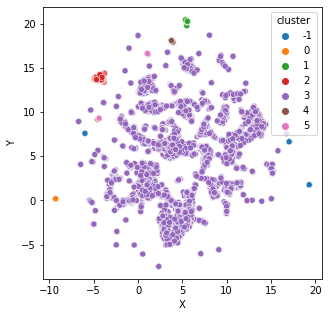

In [37]:
size = 5
plt.figure(figsize=(size,size))
df["X"] = vecs_2d[:, 0]
df["Y"] = vecs_2d[:, 1]
df["cluster"] = cluster_pred
sns.scatterplot(data=df, x="X", y="Y", hue="cluster", palette="tab10")

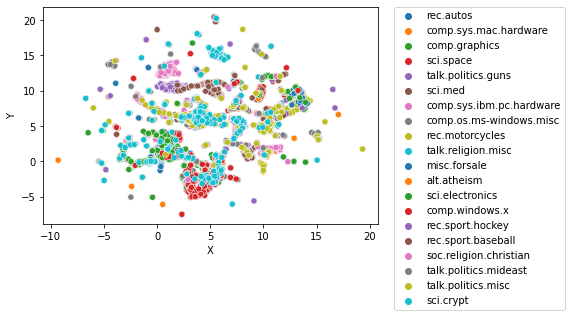

In [56]:
sns.scatterplot(data=df, x="X", y="Y", hue="title", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [45]:
tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words='english')
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(df.text.astype(str))

In [67]:
dim_reducer = UMAP(metric="hellinger", set_op_mix_ratio=1.0,
               n_components=256, random_state=42)

# UMAP reduction
dim_reduced_vecs_tfidf = dim_reducer.fit_transform(tfidf_word_doc_matrix)

In [64]:
umap_2d = UMAP(metric="hellinger", set_op_mix_ratio=1.0,
               n_components=2, random_state=42)
vecs_2d_tfidf = umap_2d.fit_transform(tfidf_word_doc_matrix)

In [68]:
cluster_model = HDBSCAN(min_cluster_size=30)
cluster_pred_tfidf = cluster_model.fit_predict(dim_reduced_vecs_tfidf)

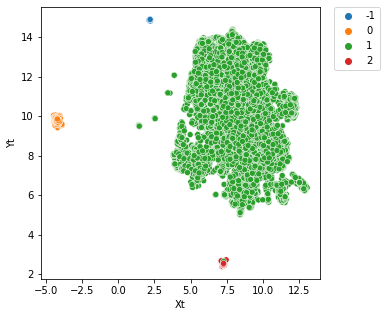

In [71]:
size = 5
plt.figure(figsize=(size,size))
df["Xt"] = vecs_2d_tfidf[:, 0]
df["Yt"] = vecs_2d_tfidf[:, 1]
df["clustert"] = cluster_pred_tfidf
sns.scatterplot(data=df, x="Xt", y="Yt", hue="clustert", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

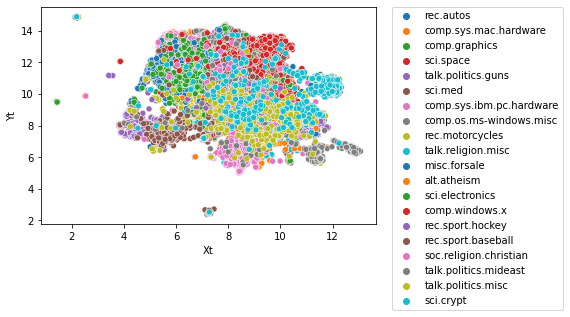

In [70]:
sns.scatterplot(data=df, x="Xt", y="Yt", hue="title", palette="tab10")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)